In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
# from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm    
from math import ceil
%matplotlib inline

# Read features


In [3]:
d_dir = "./data/ru-cola/"
subset = "dev.csv"# @param["train.csv","dev.csv","test.csv"]
model_path_tr = "./la-tda-models/ruBert-base-ru-cola_32_0.0001_lr_0.1_decay_balanced/"
model_path_nt = "./la-tda-models/ruBert-base-ru-cola_32_0.0001_lr_0.1_decay_balanced_frozen/"
# output_dir = d_dir+'results/'
# !mkdir $output_dir

___

In [4]:
df = pd.read_csv(d_dir + subset, index_col = 0)
pd.set_option('max_colwidth', 400)
y = pd.DataFrame(pd.array(df['label']))
df.sample()

,sentence,label,error_type,detailed_source
id,,,,
141,"В конце концов это было просто юношеское предчувствие, сладкие туманы, но Ганину теперь казалось, что никогда такого рода предчувствие не оправдывалось так совершенно.",1,0,Paducheva2013


In [5]:
subset = subset.split(".")[0]

In [6]:
topological_names = 's_w_e_v_c_b0_b1_m_k'.split('_')
topological_thresholds = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75]
topological_feature_names = [f'{n}_t{t}' for n in topological_names for t in topological_thresholds]

In [7]:
topological_features_tr = np.load(model_path_tr + "features/"+subset.split(".")[0] + '_s_w_e_v_c_b0b1_m_k_lists_array_' + str(len(topological_thresholds)) + '.npy')
topological_features_nt = np.load(model_path_nt + "features/"+subset.split(".")[0] + '_s_w_e_v_c_b0b1_m_k_lists_array_' + str(len(topological_thresholds)) + '.npy')
template_features_tr = np.load(model_path_tr + "features/"+ subset.split(".")[0] + '_template.npy')
template_features_nt = np.load(model_path_nt + "features/"+ subset.split(".")[0] + '_template.npy')
barcode_features_tr = np.load(model_path_tr + "features/"+subset.split(".")[0] +'_ripser.npy')
barcode_features_nt = np.load(model_path_nt + "features/"+ subset.split(".")[0] + '_ripser.npy')

In [8]:
NUM_layers = topological_features_nt.shape[0]
NUM_heads = topological_features_nt.shape[1]
NUM_layers, NUM_heads

(12, 12)

# Feature-targets correlation


In [9]:
#@title draw_heatmaps_trained_nontrained
def draw_heatmaps_trained_nontrained(
                                 sf,
                                 thresholds=[],
                                 vmin=None,
                                 vmax=None,
                                 transpose=False,
                                 stats_name="",
                                 title=None,
                                 annot=None,
                                 annot_color='w',
                                 color_scheme='coolwarm',
                                 figsize=(14,5),
                                 pad=0.5,
                                 ticks=[i for i in range(12)],
                                 ticks_font_size=9,
                                 precision=2,
                                 labels_font_size=10,
                                 annot_font_size=10,
                                 subtitles_font_size=16,
                                 subtitles_pad=12,
                                 enable_grid=False,
                                 zorder=0,
                                 pdf_file=None,
                                 norm = None,
                                 topological = True):
    if vmax is None or vmin is None:
        vmin =  1e10
        vmax = -1e10
        for j in range(len(sf)):
            surfaces = sf[j]
            for array in surfaces.values():
                vmax = max(vmax, max(array.flatten()))
                vmin = min(vmin, min(array.flatten()))
            if not norm:
                vmax = 1
                vmin = -1

    plots_dim = len(sf)
    if not transpose:
        fig, axs = plt.subplots(len(sf[0].keys()), plots_dim, squeeze=False)
    else:
        fig, axs = plt.subplots(plots_dim, len(sf[0].keys()), squeeze=False)
    fig.set_size_inches(figsize)
    fig.tight_layout(pad=pad)
    for j in range(len(sf)):
        surfaces = sf[j]
        k = 0
        for key in sorted(surfaces.keys()):
            Z = surfaces[key]
            cell_num = (k, j) if not transpose else (j, k)
            if norm:
                cp = axs[cell_num].imshow(Z, interpolation='none', cmap=color_scheme, vmin=vmin, vmax=vmax, norm = norm)
            else:
                cp = axs[cell_num].imshow(Z, interpolation='none', cmap=color_scheme, vmin=vmin, vmax=vmax)
            if labels_font_size > 0:
                axs[cell_num].set_xlabel('head',  fontsize=subtitles_font_size)
                axs[cell_num].set_ylabel(key + '\nlayer', fontsize=subtitles_font_size)
            if k == 0:
                value = ''
                try: 
                    value = thresholds[j]
                except:
                    value = ''
                if subtitles_font_size > 0:
                    axs[cell_num].set_title(value, fontsize=subtitles_font_size, pad=subtitles_pad)
                else:
                    axs[cell_num].set_title(value)
                
            axs[cell_num].set_xticks(ticks)
            axs[cell_num].set_yticks(ticks)
            for tick in axs[cell_num].xaxis.get_major_ticks():
                tick.label.set_fontsize(ticks_font_size)
            for tick in axs[cell_num].yaxis.get_major_ticks():
                tick.label.set_fontsize(ticks_font_size)
            if enable_grid:
                axs[cell_num].xaxis.grid(True, color='black', zorder=zorder)
                axs[cell_num].yaxis.grid(True, color='black', zorder=zorder)
            
            if annot is not None:
                for y in range(Z.shape[0]):
                    for x in range(Z.shape[1]):
                        formatstring = "{:." + str(precision) + "f}"
                        axs[cell_num].text(x,
                                 y,
                                 formatstring.format(annot[j][key][y, x]),
                                 fontsize=annot_font_size, 
                                 color=annot_color, 
                                 horizontalalignment='center',
                                 verticalalignment='center')
            k += 1
    common_cb = fig.colorbar(cp, ax=axs[:, :])
    common_cb.ax.tick_params(labelsize=subtitles_font_size)
    for ax in axs.flat:
        ax.label_outer()
    args = {}
    if thresholds:
        args = {'x' : 0.4}
        plt.subplots_adjust(top=0.75, bottom=0.1, left=0.07, right=0.81, hspace=0.15, wspace=0.15)
    if topological:
        title = title + '\n\nthresholds' if thresholds else title
    else:
        title = 'features'
    fig.suptitle(title, fontsize=subtitles_font_size, **args)
    if pdf_file is not None:
        pdf_file.savefig()
    plt.show()

In [10]:
#@title functions for getting features values
def topological_get_layer_head(features, layer, head):
    df = features[layer,head,:,:,:]
    df = np.moveaxis(df, 0, -1)
    df = np.moveaxis(df, 2,  1)
    nfeat = df.shape[1]
    nthrs = df.shape[2]
    df = df.reshape((df.shape[0], nfeat * nthrs))
    return pd.DataFrame(df, columns=topological_feature_names)

def barcode_get_layer_head(features, layer, head):
    return pd.DataFrame(features[layer,head,:,:], columns=barcode_feature_names)

def template_get_layer_head(features, layer, head):
    df = features[layer,head,:,:]
    return pd.DataFrame(df.T, columns=template_feature_names)
def corr(X):
    """Return an array of correlation coefs between features and targets
    :param X: np.array of the shape(y.shape[0], number of features + 1 (targets))
    :rtype: np.array of corr.coefs
    """
    C = np.corrcoef(X, rowvar=False)
    np.fill_diagonal(C, 0)
    C[np.isnan(C)] = 0
    return C[:,-1]
def stat(X):
    """Return an array of p-values
 
    :param X: np.array of the shape(y.shape[0], number of features + 1 (targets))
    :rtype: np.array of p-values
    """
    y = X['y']
    values_1 = np.argwhere(y.values == 1) # correct sents
    values_0 = np.argwhere(y.values == 0) # incorrect sents
    ps = []
    for col in range(X.shape[1]-1):
        top_values_0 = X.to_numpy()[:, col][values_0]
        top_values_1 = X.to_numpy()[:, col][values_1]
        try:
            _, pval = mannwhitneyu(top_values_0, top_values_1,  alternative = 'two-sided')
            ps.append(pval)
        except:
            # the case of the 1 unique value in the feature values
            # print(f'For the feature {names[col]} all values are the same, layer {layer}, head {head}')
            ps.append(0.9)
    ps = np.array(ps)
    return ps
def get_matrices(features, func, y, names, type_ = corr):
    """Return a matrix filled with correlation coefficients, p-values, or roc auc scores
 
    :param features: np.array of features, of the shape (NUM_layers, NUM_heads)
    :param func: function object for getting features[l, h] out of the features
    :param y: pd.array/np.array of target.values
    :param names: list of features' names
    :param type_: 'corr' or 'stat' or 'auc' - types of coefficients (function's name), 
                    default corr

    :rtype: matrix of the shape (NUM_layers, NUM_heads)
    """
    m = {}
    for name in names:
        if name not in m:
            m[name] = np.zeros((NUM_heads, NUM_layers))
            m[name][:,:] = -10
    function = type_
    for layer in range(NUM_layers):
        for head in range(NUM_heads):
            X = func(features, layer, head)
            X['y'] = y
            values = function(X)
            for i,name in enumerate(names):
                m[name][layer,head] = values[i]
    max_or_min = False if type_ == stat else True
    show_max_matrices(m, max_or_min)
    return m
def show_max_matrices(mtrs, max_val = True):
    """Print max/min values of matrices and its indices: 
    feature: value  layer head
    """
    for f in mtrs:
        m = mtrs[f]
        coord = np.argmin(np.abs(m), axis=None)
        if max_val: 
            coord = np.argmax(np.abs(m), axis=None)
        i, j = np.unravel_index(coord, m.shape)
        vmax = m[i,j]
        print(f'{f}: {vmax}  {i} {j}')
    return
def feat_construction(f, t, topological):
    """
    returns a feat

    :param f: feature name if topological
    :param t: threshold
    :param topological: True if topological else False

    :rtype: string of feature with a threshold if topological
    """
    if topological:
        return f"{f}_t{t}"
    else:
        return f"{t}"
def make_comparison_data(m_tr, m_nt, feature, names, topological = False):
    data = []
    ths = []
    t = 0
    def find_feature_val(t_or_f):
        feat = feat_construction(feature, t_or_f, topological)
        data.append({'trained': m_tr[feat], 'non-trained': m_nt[feat]})
        ths.append(t_or_f)
    if topological:
        for _, t in enumerate(topological_thresholds):
            find_feature_val(t)
    else:
        for f in names:
            find_feature_val(f)
    return data, ths

## Topological features

In [11]:
topological_titles = {
    's': 'Connected strong components',
    'w': 'Connected weak components',
    'e': 'Edge number',
    'v': 'Avg. vertix degree',
    'c': 'Simple cycles',
    'b0': 'Betty 0',
    'b1': 'Betty 1',
    "k": "Chordality",
    "m": "Matching #"
}

In [12]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(topological_features_tr, topological_get_layer_head, y, names=topological_feature_names)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(topological_features_nt, topological_get_layer_head, y, names=topological_feature_names)

Fine-tuned model

s_t0.025: -0.27579845467192554  11 7
s_t0.05: -0.24606612037002867  9 2
s_t0.1: -0.24176608416852538  6 11
s_t0.25: -0.23274898344238878  4 3
s_t0.5: -0.2292129636848271  4 3
s_t0.75: -0.2236595663119048  6 11
w_t0.025: -0.11294161281577092  4 2
w_t0.05: -0.16681286303712017  3 11
w_t0.1: -0.27487348864993516  11 2
w_t0.25: -0.40365023081246876  11 3
w_t0.5: -0.422647691151636  11 3
w_t0.75: -0.4331816655010405  11 10
e_t0.025: -0.4374853120875808  11 10
e_t0.05: -0.4559332164220687  11 10
e_t0.1: -0.4375138910737861  11 10
e_t0.25: -0.2502971804623076  9 5
e_t0.5: -0.23350965530612788  5 4
e_t0.75: -0.24460332127843742  5 11
v_t0.025: -0.4390967815224948  11 11
v_t0.05: -0.42488976366010367  11 11
v_t0.1: -0.39302494659557086  11 4
v_t0.25: 0.3143682063195771  11 5
v_t0.5: 0.41499689889117675  11 10
v_t0.75: 0.4156904876971084  11 11
c_t0.025: -0.4387368379439932  11 11
c_t0.05: -0.4508472984946412  11 10
c_t0.1: -0.42752209113706185  11 11
c_t0.25: -0.38270214934111

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


b0_t0.025: -0.11294161281577092  4 2
b0_t0.05: -0.16681286303712017  3 11
b0_t0.1: -0.27487348864993516  11 2
b0_t0.25: -0.40365023081246876  11 3
b0_t0.5: -0.422647691151636  11 3
b0_t0.75: -0.4331816655010405  11 10
b1_t0.025: -0.43087350808010205  11 11
b1_t0.05: -0.4505207274131344  11 3
b1_t0.1: -0.44924234941155844  11 10
b1_t0.25: -0.3343646580550553  11 4
b1_t0.5: -0.28706643871476945  11 9
b1_t0.75: 0.2522217238186623  9 7
m_t0.025: -0.46471615879869704  11 11
m_t0.05: -0.47920082888030296  11 11
m_t0.1: -0.4604533034528556  11 10
m_t0.25: -0.4164254757144421  10 11
m_t0.5: -0.3477748782618523  10 10
m_t0.75: 0.35655418551546253  11 2
k_t0.025: 0.35967877113634994  11 11
k_t0.05: 0.3645224157324437  11 4
k_t0.1: 0.36667049423310366  11 5
k_t0.25: 0.24356248660964708  10 11
k_t0.5: -0.03231213141997497  7 7
k_t0.75: -0.01863641072031375  5 2
Model with frozen weights

s_t0.025: -0.23309288728533653  5 11
s_t0.05: -0.22589400569364088  1 9
s_t0.1: -0.23704328877525158  6 9
s_t0.

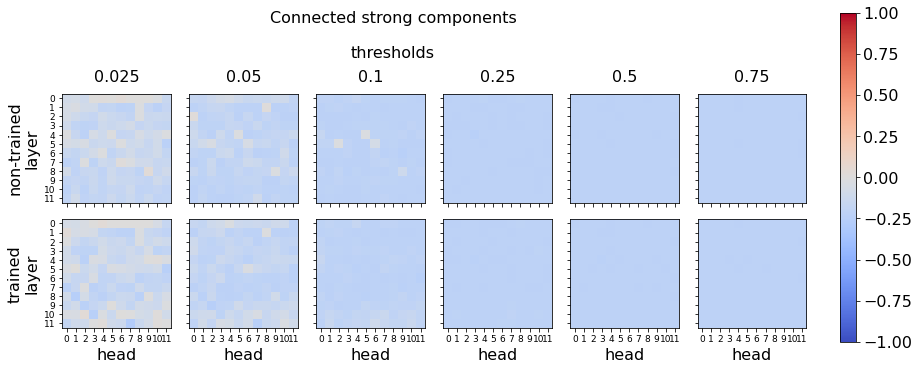

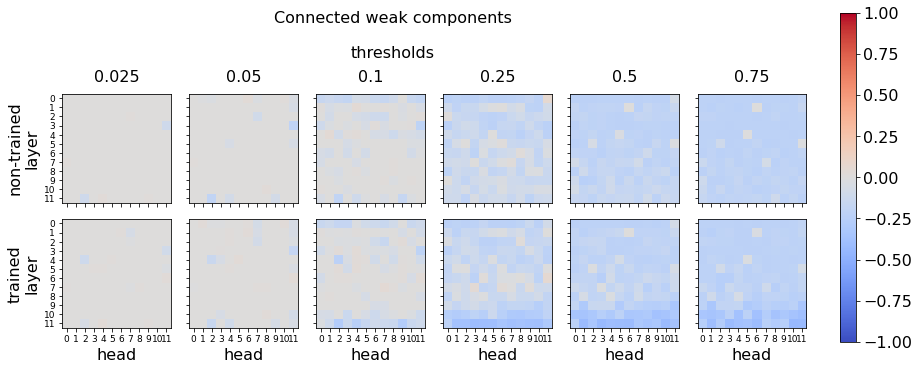

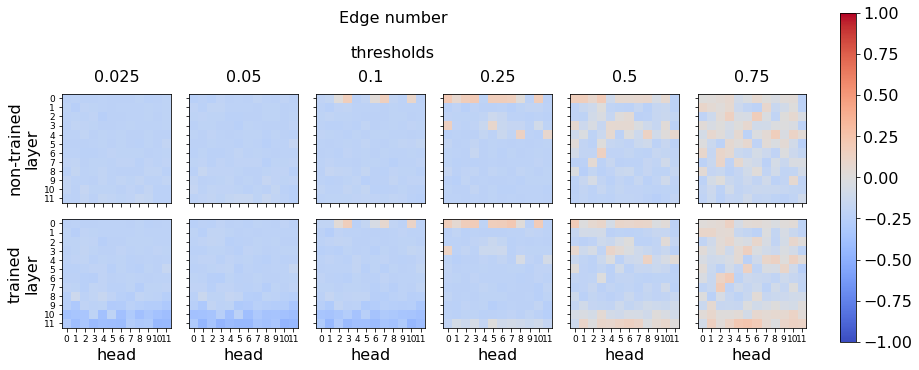

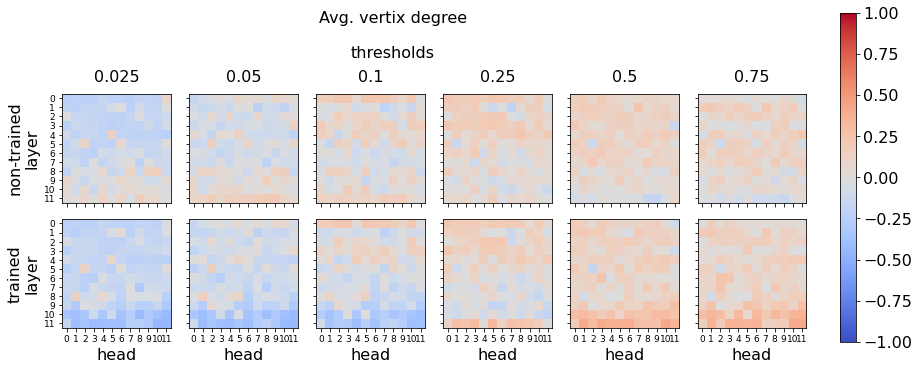

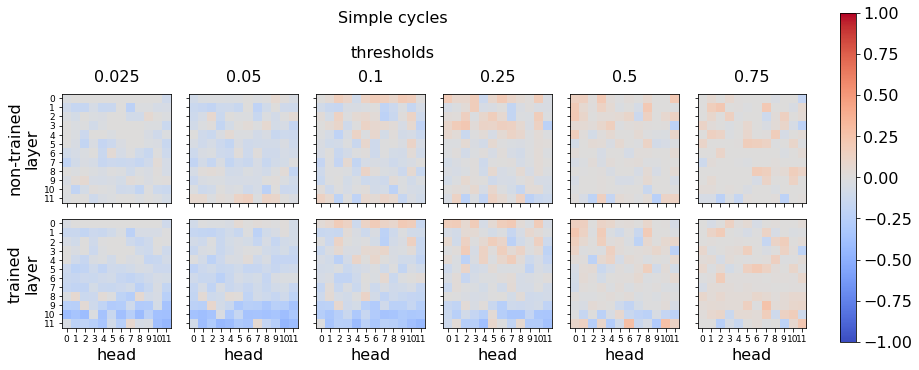

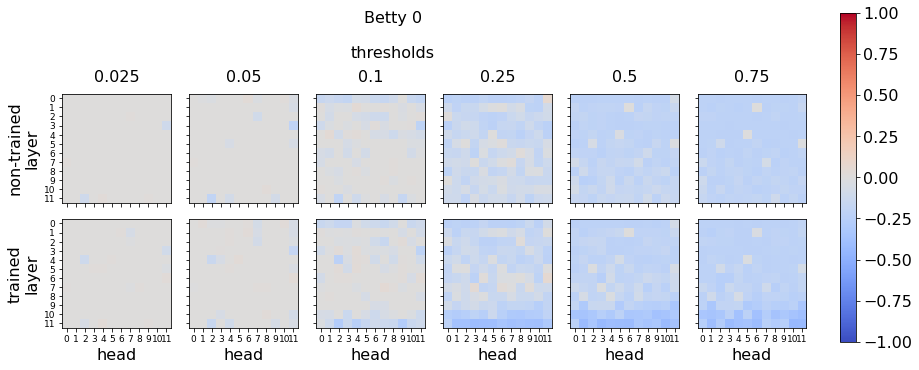

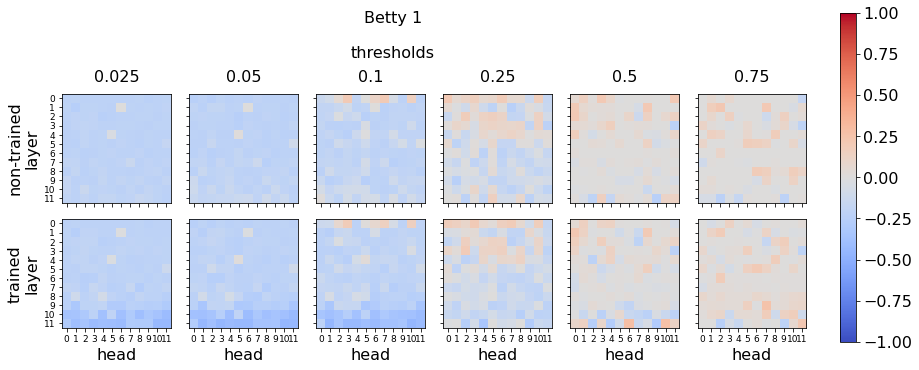

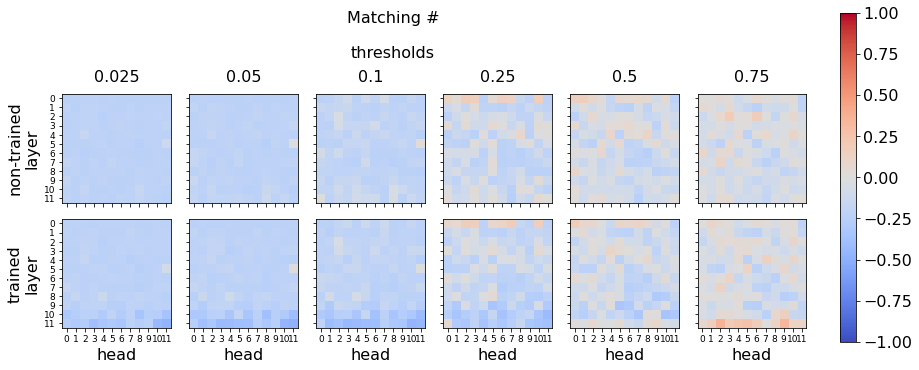

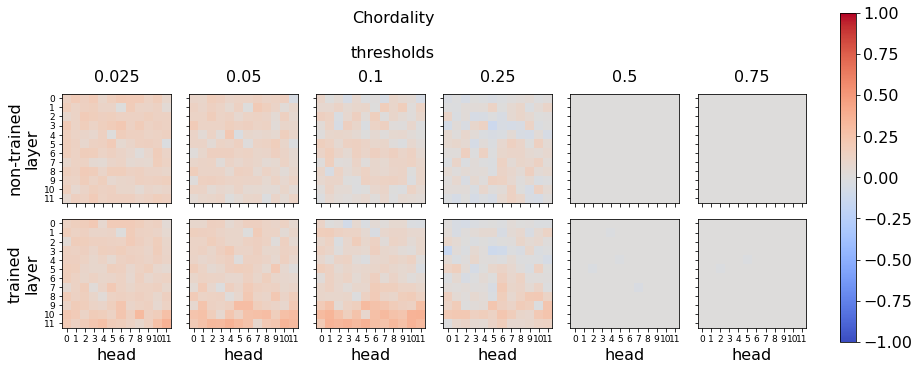

In [13]:
for f in topological_names:
    data, ths = make_comparison_data(matrices_tr, matrices_nt, f, names = topological_names, topological = True)
    draw_heatmaps_trained_nontrained(data,thresholds = topological_thresholds, title=topological_titles[f], )

## Ripser features

In [14]:
barcode_feature_names = [
    'h0_s', 
    'h0_e',
    'h0_t_d', 
    'h0_n_d_m_t0.75',
    'h0_n_d_m_t0.5',
    'h0_n_d_l_t0.25',
    'h1_t_b',
    'h1_n_b_m_t0.25',
    'h1_n_b_l_t0.95', 
    'h1_n_b_l_t0.70',  
    'h1_s',
    'h1_e',
    'h1_v',
    'h1_nb'
]
barcode_titles = {
    'h0_s': 'h0, sum of lengths', 
    'h0_e': 'h0, entropy',
    'h0_t_d': 'h0, death time', 
    'h0_n_d_m_t0.75': '#h0, death time > t_0.75',
    'h0_n_d_m_t0.5':'#h0, death time > t_0.5',
    'h0_n_d_l_t0.25':'#h0, death time < t_0.25',
    'h1_t_b':'h1, birth time',
    'h1_n_b_m_t0.25':'#h1, birth time > t_0.25',
    'h1_n_b_l_t0.95':'#h1, birth time < t_0.95', 
    'h1_n_b_l_t0.70':'#h1, birth time < t_0.7',  
    'h1_s':'h1, sum of lengths',
    'h1_e':'h1, entropy',
    'h1_v':'h1, variance of lengths',
    'h1_nb':'number of barcodes in h1' }

Fine-tuned model

h0_s: -0.4458588839745173  11 10
h0_e: -0.2878792171151795  11 10
h0_t_d: -0.4885267078538728  11 11
h0_n_d_m_t0.75: -0.40365023081246876  11 3
h0_n_d_m_t0.5: -0.42344036712065164  11 3
h0_n_d_l_t0.25: 0.2480445559879023  11 9
h1_t_b: -0.4375726276705123  11 5
h1_n_b_m_t0.25: -0.3828199517487239  10 7
h1_n_b_l_t0.95: -0.37828546151831405  10 7
h1_n_b_l_t0.70: -0.23388741427701049  9 11
h1_s: -0.35061685747913107  10 7
h1_e: -0.3943014870487317  10 7
h1_v: -0.3551111024960191  9 5
h1_nb: -0.3828199517487239  10 7
Model with frozen weights

h0_s: -0.23671732394915088  10 11
h0_e: -0.25196750302588444  11 10
h0_t_d: -0.23316837005854452  4 8
h0_n_d_m_t0.75: -0.22992360089475777  3 0
h0_n_d_m_t0.5: -0.2366320174203169  9 1
h0_n_d_l_t0.25: -0.23805557404162803  5 11
h1_t_b: -0.21819761887362749  6 2
h1_n_b_m_t0.25: -0.2410717065884621  2 0
h1_n_b_l_t0.95: -0.24078831593869768  2 0
h1_n_b_l_t0.70: -0.18078150303060123  1 5
h1_s: -0.21898513992216914  5 6
h1_e: -0.2402981857

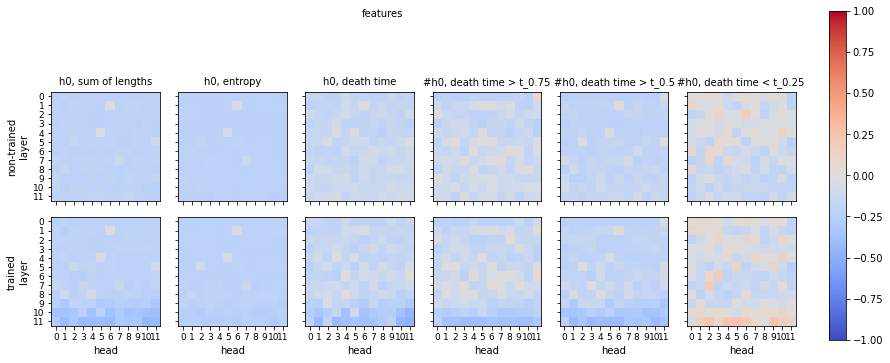

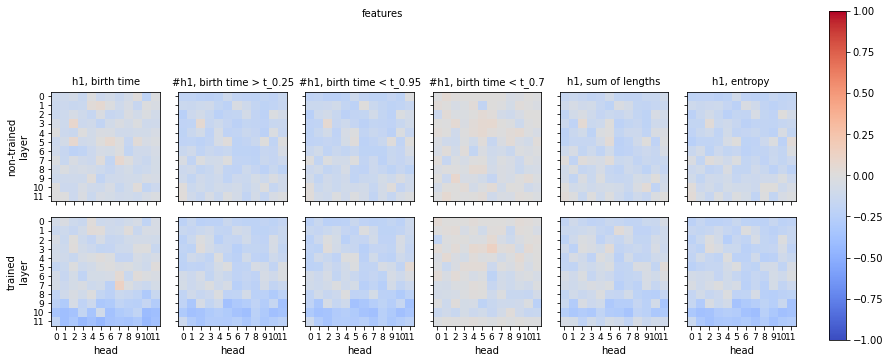

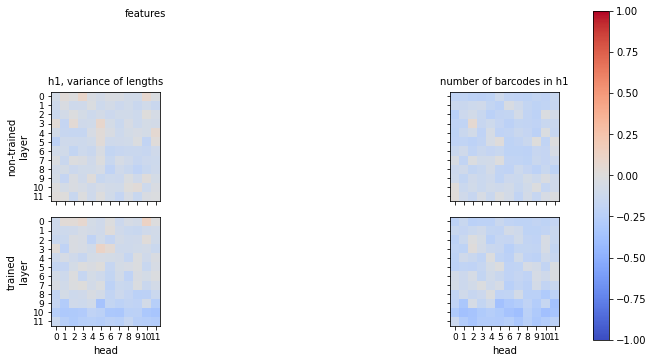

In [15]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(barcode_features_tr, barcode_get_layer_head, y, names=barcode_feature_names)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(barcode_features_nt, barcode_get_layer_head, y, names=barcode_feature_names)
start = 0
for _ in range(ceil(len(barcode_feature_names)/6)):
    names_i = [barcode_titles[i] for i in barcode_feature_names[start:start+6]]
    data, ths = make_comparison_data(matrices_tr, matrices_nt, barcode_feature_names[start:start+6], names = barcode_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=names_i,subtitles_font_size=10,
                                 subtitles_pad=7, topological = False)
    start +=6

## Template features

In [16]:
template_feature_names = [
    'self',
    'beginning',
    'prev',
    'next',
    'comma',
    'dot', 
    'sep']

Fine-tuned model

self: 0.4717415471619973  11 10
beginning: 0.3757341161693713  11 10
prev: 0.41196371900950957  10 11
next: 0.39786333472277124  11 11
comma: 0.32193407309416705  11 10
dot: 0.3612780231106466  10 8
sep: -0.42222368618414996  11 6
Model with frozen weights

self: 0.25177453873265465  6 9
beginning: -0.2328381686664496  0 5
prev: 0.25556916723417733  11 7
next: 0.2405584129705641  4 11
comma: 0.2050284104863829  9 2
dot: 0.17442861022357106  1 10
sep: -0.23827617219303504  3 4


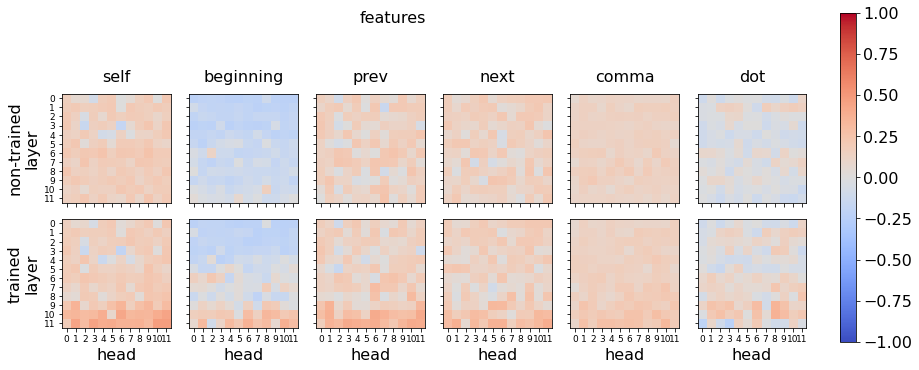

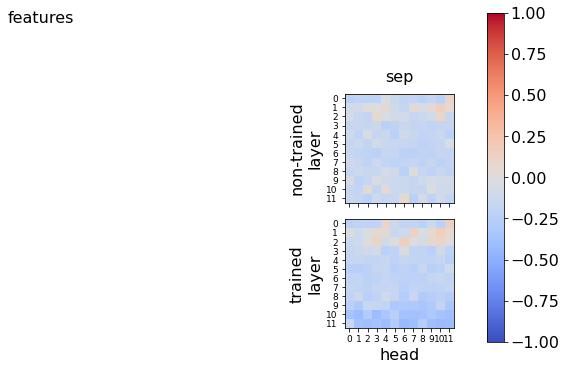

In [17]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(template_features_tr, template_get_layer_head, y, names=template_feature_names)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(template_features_nt, template_get_layer_head, y, names=template_feature_names)
start = 0
for _ in range(ceil(len(template_feature_names)/6)):
    data, ths = make_comparison_data(matrices_tr, matrices_nt, template_feature_names[start:start+6], names = template_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=template_feature_names[start:start+6], topological = False)
    start +=6

# Features Mann-Whitney p-values

## Topological features

Fine-tuned model

s_t0.025: 1.0746036455141014e-16  11 7
s_t0.05: 3.913321568943692e-14  9 2
s_t0.1: 4.0480562111103487e-14  6 11
s_t0.25: 6.882805873223268e-13  4 3
s_t0.5: 1.045675202836094e-12  4 3
s_t0.75: 6.544629225374308e-12  6 11
w_t0.025: 0.00022297882720824334  3 11
w_t0.05: 1.240766214184512e-08  3 11
w_t0.1: 4.957311817572863e-16  11 2
w_t0.25: 8.440292550484563e-44  11 3
w_t0.5: 2.127019641132738e-43  11 10
w_t0.75: 3.4285558282693856e-45  11 11
e_t0.025: 2.9254904485839383e-40  11 11
e_t0.05: 2.0754496421297208e-39  11 3
e_t0.1: 3.217714100278527e-36  11 10
e_t0.25: 6.602256880612053e-17  9 5
e_t0.5: 3.746160015774851e-12  0 11
e_t0.75: 2.1707316534338256e-17  11 5
v_t0.025: 4.024161730870982e-34  11 11
v_t0.05: 7.781808586761925e-36  10 11
v_t0.1: 1.1855700354266926e-36  10 11
v_t0.25: 8.91805295326442e-22  10 11
v_t0.5: 1.2041828141069569e-39  11 10
v_t0.75: 2.316009387834154e-36  11 11
c_t0.025: 4.065312306646607e-38  11 11
c_t0.05: 1.322595780128423e-35  11 11
c_t0.1:

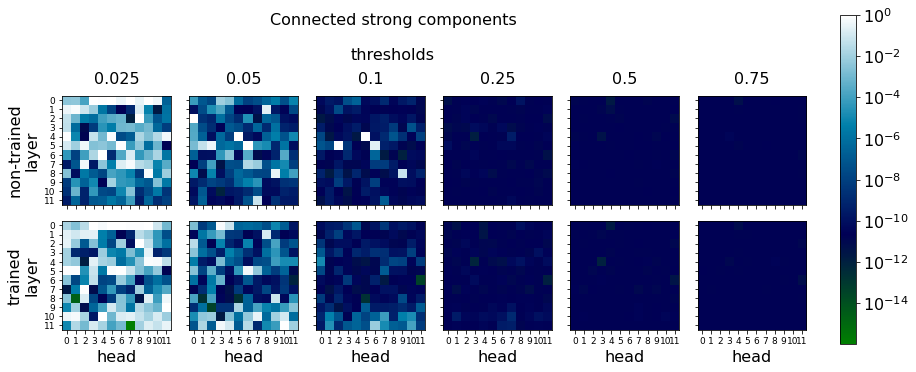

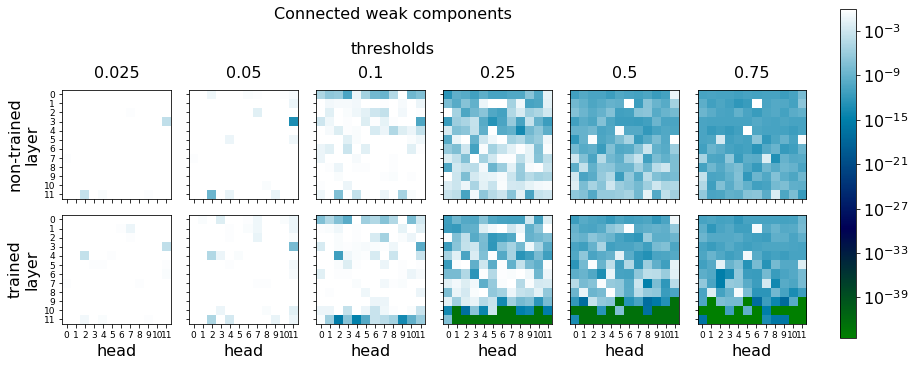

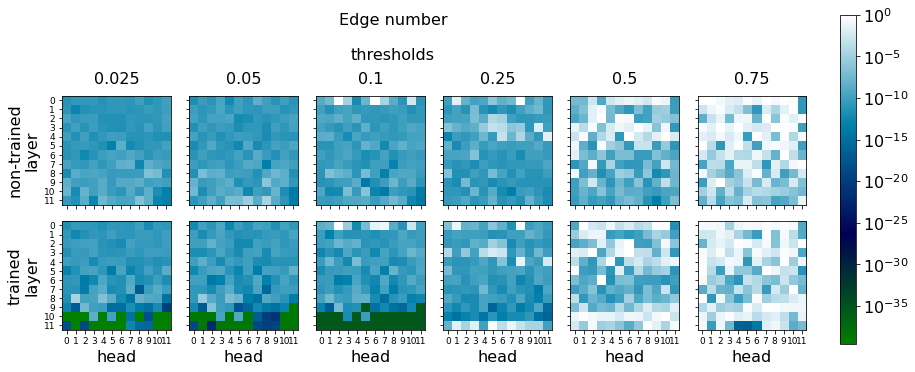

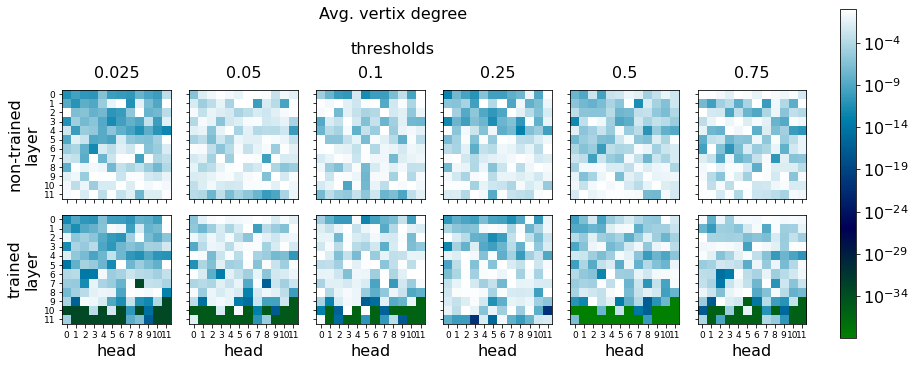

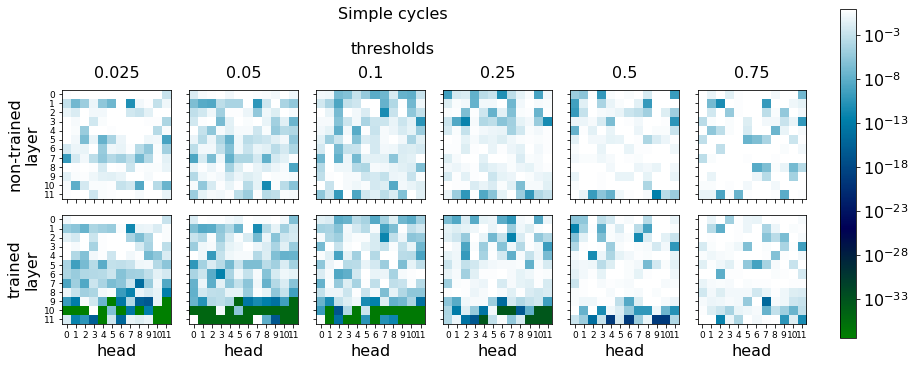

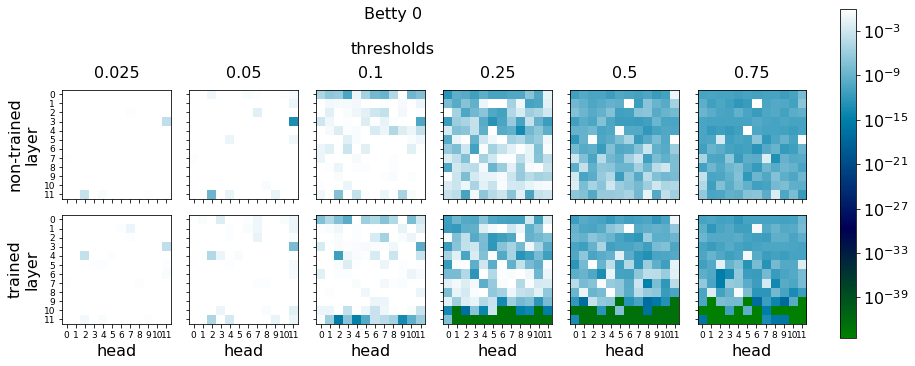

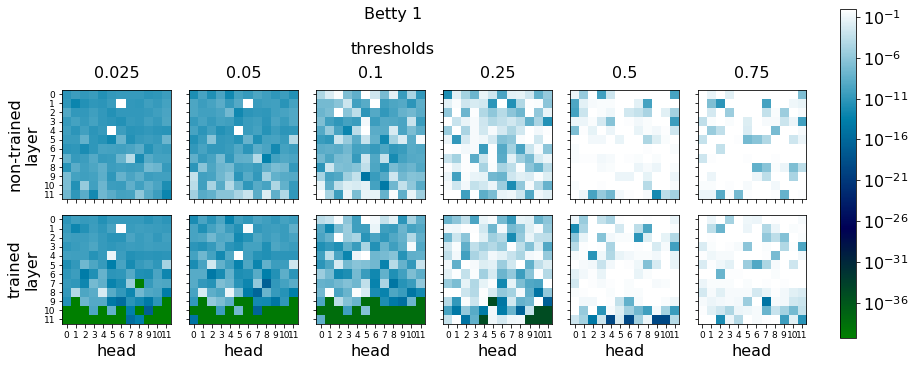

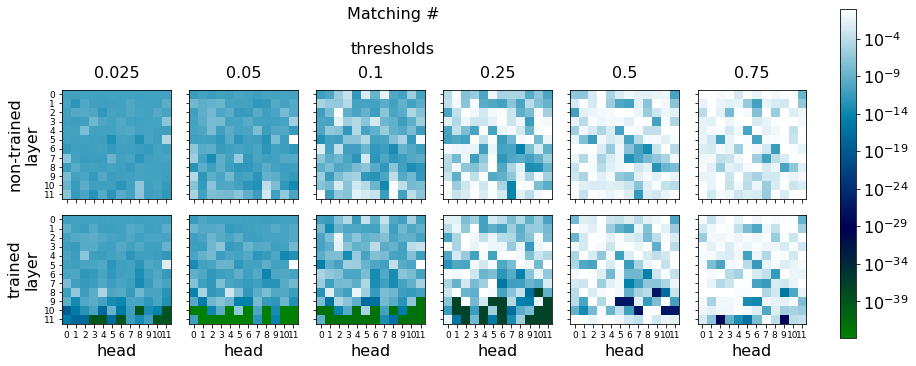

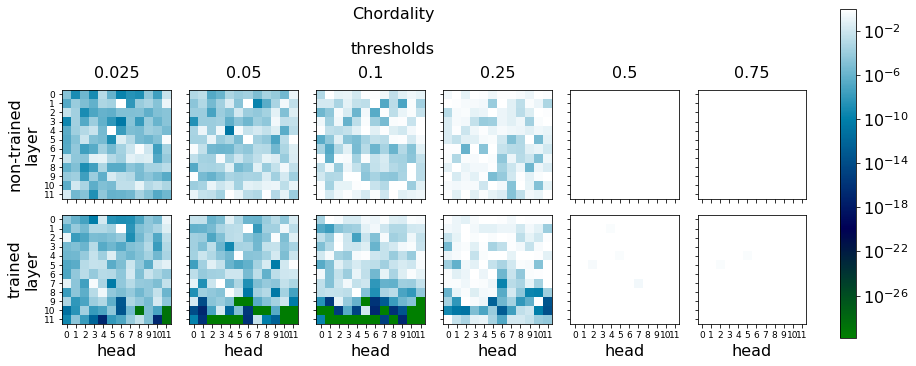

In [18]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(topological_features_tr, topological_get_layer_head, y, names=topological_feature_names, type_ = stat)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(topological_features_nt, topological_get_layer_head, y, names=topological_feature_names, type_ = stat)
for f in topological_names:
    data, ths = make_comparison_data(matrices_tr, matrices_nt, f, names = topological_names, topological = True)
    draw_heatmaps_trained_nontrained(data,thresholds = topological_thresholds, color_scheme = 'ocean', 
                                     title=topological_titles[f], norm=LogNorm())

## Ripser features

Fine-tuned model

h0_s: 5.83936836913524e-42  11 11
h0_e: 2.463846930754524e-18  10 2
h0_t_d: 1.823533679227845e-42  11 11
h0_n_d_m_t0.75: 8.440292550484563e-44  11 3
h0_n_d_m_t0.5: 2.571495451410339e-43  11 10
h0_n_d_l_t0.25: 3.8581446917472506e-21  11 9
h1_t_b: 1.0029944087704043e-42  11 5
h1_n_b_m_t0.25: 5.774253454841161e-41  11 5
h1_n_b_l_t0.95: 2.932340277591157e-41  11 5
h1_n_b_l_t0.70: 3.883316727106267e-12  9 11
h1_s: 3.2766262477715838e-40  11 5
h1_e: 1.9000472623541153e-36  10 10
h1_v: 6.019205441648297e-35  10 10
h1_nb: 5.774253454841161e-41  11 5
Model with frozen weights

h0_s: 1.2539315655287902e-15  11 11
h0_e: 4.019546312595398e-15  11 10
h0_t_d: 1.3391499042243603e-13  4 8
h0_n_d_m_t0.75: 2.3629677580735137e-14  4 8
h0_n_d_m_t0.5: 9.77627661985357e-13  4 8
h0_n_d_l_t0.25: 1.5178961502691353e-11  5 6
h1_t_b: 1.6134533133324782e-12  0 7
h1_n_b_m_t0.25: 3.8323329284586413e-13  5 0
h1_n_b_l_t0.95: 3.730319946319358e-13  5 0
h1_n_b_l_t0.70: 5.504957364333677e-08  1 5
h1_s:

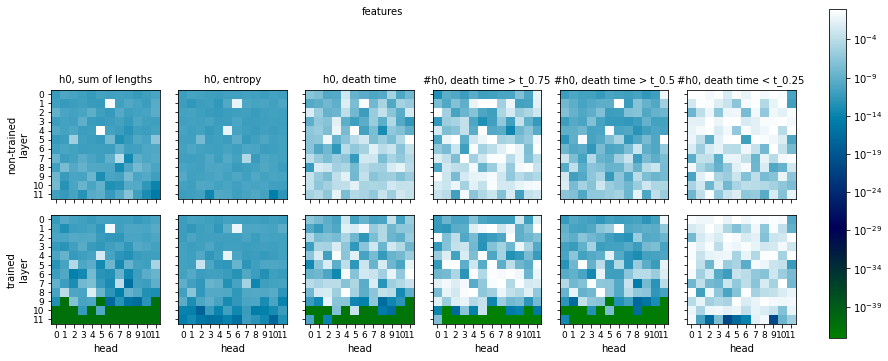

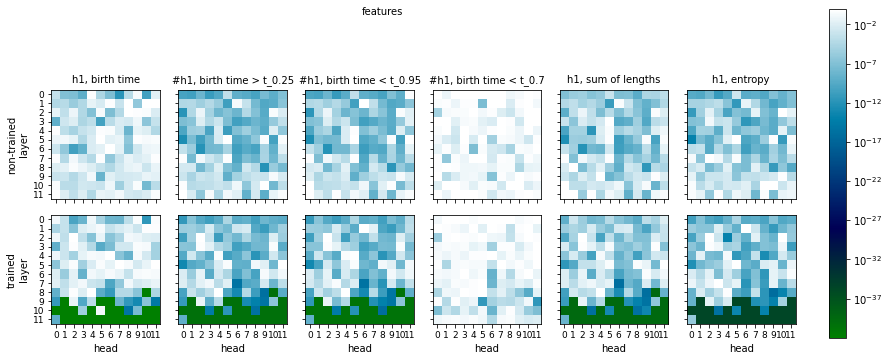

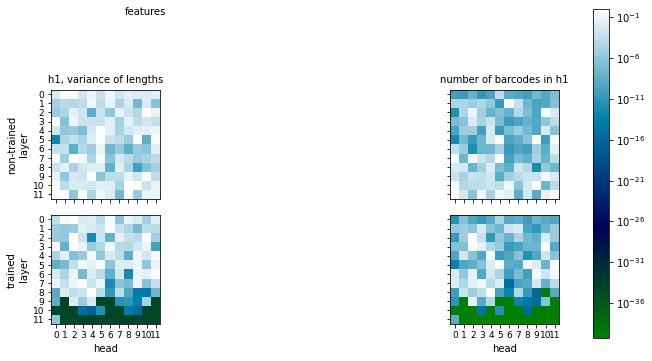

In [19]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(barcode_features_tr, barcode_get_layer_head, y, names=barcode_feature_names, type_ = stat)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(barcode_features_nt, barcode_get_layer_head, y, names=barcode_feature_names, type_ = stat)
start = 0
for _ in range(ceil(len(barcode_feature_names)/6)):
    names_i = [barcode_titles[i] for i in barcode_feature_names[start:start+6]]
    data, ths = make_comparison_data(matrices_tr,matrices_nt, barcode_feature_names[start:start+6], 
                                     names = barcode_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=names_i, subtitles_font_size=10,
                                subtitles_pad=7, topological = False, color_scheme = 'ocean', norm=LogNorm())
    start +=6

##Template features

Fine-tuned model

self: 1.9864916759572426e-35  11 11
beginning: 2.069615934346131e-21  11 10
prev: 5.702343446171502e-32  11 6
next: 1.864397405752007e-29  11 6
comma: 1.928172484740315e-15  10 11
dot: 2.613442778015888e-21  10 8
sep: 2.2852873226478918e-35  11 6
Model with frozen weights

self: 1.0060561039013853e-14  6 9
beginning: 1.0386086549520462e-12  0 5
prev: 5.484952599917771e-16  8 10
next: 5.813732686633782e-15  9 5
comma: 1.3154132216146685e-09  7 5
dot: 9.843531422363805e-09  1 3
sep: 4.86062324242567e-14  11 7


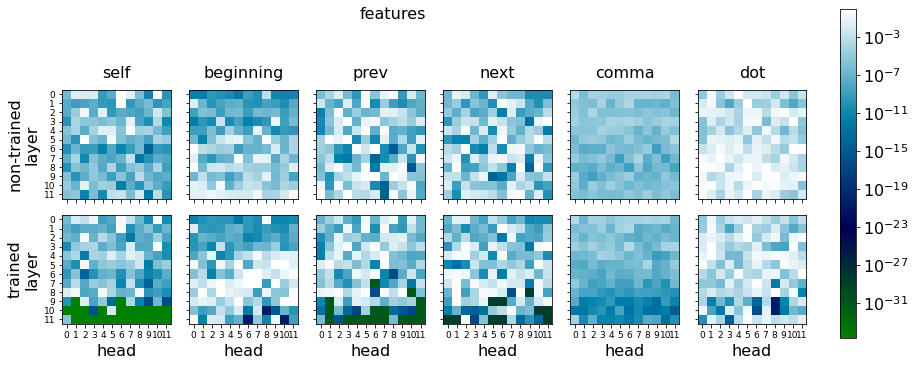

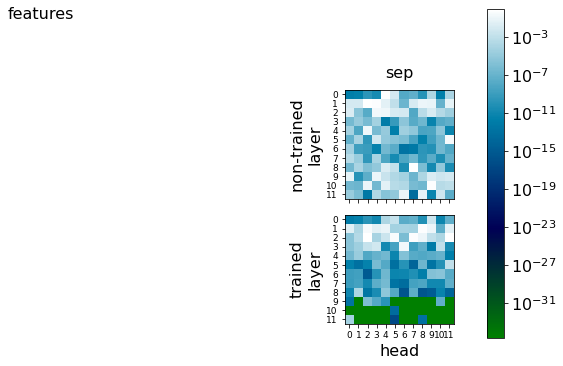

In [20]:
print("Fine-tuned model", end='\n\n')
matrices_tr = get_matrices(template_features_tr, template_get_layer_head, y, names=template_feature_names, type_ = stat)
print("="*6)
print("Model with frozen weights", end='\n\n')
matrices_nt = get_matrices(template_features_nt, template_get_layer_head, y, names=template_feature_names, type_ = stat)
start = 0
for _ in range(ceil(len(template_feature_names)/6)):
    data, ths = make_comparison_data(matrices_tr, matrices_nt, template_feature_names[start:start+6], names = template_feature_names[start:start+6])
    draw_heatmaps_trained_nontrained(data, thresholds=template_feature_names[start:start+6], color_scheme = 'ocean',topological = False, norm=LogNorm())
    start +=6